# Lab 7



*   Kernel density estimation

## Kernel Density Estimation

**Kernel density estimation (KDE)** is a non-parametric method to estimate the probability density function of a random variable based on kernels as weights.

**Kernel** is a fuction that satisfies the following criteria:


1.   symmetrical;
2.   the area under the curve of a kernel is 1;
3.   non-negative.



Let $X_1, X_2, \dots, X_n$ be independent random variables identically distributed with probability density function $f(x)$.

$F(x) = P[X \leq x]$ is their distribution function.

As an estimate of $f(x)$ one might take:

$$f_n(x) = \frac{F_n(x+h)-F_n(x-h)}{2h},$$

where h is a suitable chosen positive number.

However, how should one choose $h$? It is clear that $h$ should be chosen as a function of $n$ which tends to $0$ as $n$ tends to $\infty$. But how fast should $h$ tend to $0$? In order to answer this question we will have to study the statistical properties of the estimate we have defined.

Let $K(y)$ be a function defined by:

$$K(y) = \begin{cases}
    \frac{1}{2}, & \text{for } |y| \leq 1 , \\
    0 & \text{for } |y| > 1.
  \end{cases}$$

Then

$$f_n(x) = \int_{-\infty}^{+\infty}\frac{1}{h}K(\frac{x-y}{h})dF_n(y) = \frac{1}{nh}\sum_{j=1}^nK(\frac{x-X_j}{h}),$$

where

$$F_n(x) = \frac{1}{n}.$$

We are thus led to the problem of stydying the statistical properties of estimates above where $h$ and $K(y)$ are suitably chosen.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize
from sklearn.neighbors import KernelDensity

In [8]:
rand_seed = 100
np.random.seed(rand_seed)

In [9]:
def make_data_uniform(data_count=100):
    alpha = 0.3
    x = np.concatenate([
        np.random.uniform(-1, 1, int(data_count * alpha)),
        np.random.uniform(0, 1, int(data_count * (1 - alpha)))
    ])
    dist = lambda z: alpha * stats.uniform(-1, 1).pdf(z) + (1 - alpha) * stats.uniform(0, 1).pdf(z)
    return x, dist

In [10]:
def kernel():
    """Kernel Functions.
    Ref: https://en.wikipedia.org/wiki/Kernel_(statistics)
    """
    return lambda u: 1 / np.sqrt(2 * np.pi) * np.exp(-1/2 * u**2) #gaussian kernel

def bw_scott(data):
    """Bandwidth selection.
    Ref: https://en.wikipedia.org/wiki/Kernel_density_estimation

    Args:
        data (np.ndarray): Data
    """
    std_dev = np.std(data, axis=0, ddof=1)
    n = len(data)
    return 1.059 * std_dev * n ** (-0.2)

def kde(data, k=None, h=None, x=None):
    """Kernel Density Estimation.

    Args:
        data (np.ndarray): Data.
        k (function): Kernel function.
        h (float): Bandwidth.
        x (np.ndarray, optional): Grid. Defaults to None.

    Returns:
        np.ndarray: Kernel density estimation.
    """
    if x is None:
        x = np.linspace(np.min(data), np.max(data), 1000)
    if h is None:
        h = bw_scott(data)
    if k is None:
        k = kernel()
    n = len(data)
    kde = np.zeros_like(x)
    for j in range(len(x)):
        for i in range(n):
            kde[j] += k((x[j] - data[i]) / h)
        kde[j] /= n * h
    return kde

What is happening in KDE?

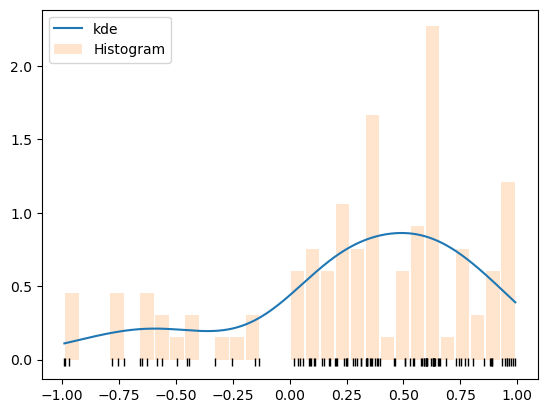

In [11]:
# plot kde
x_uni, dist_exp = make_data_uniform()
x = np.linspace(np.min(x_uni), np.max(x_uni), 1000)
kde_norm = kde(x_uni, k=None, h=None)
plt.plot(x, kde_norm, label='kde')
plt.hist(x_uni, density=True, alpha=0.2, label='Histogram', bins=30, rwidth=0.9)
plt.plot(x_uni, np.full_like(x_uni, -0.02), '|k', markeredgewidth=1)
plt.legend()
plt.show()

In [12]:
def generate_data(seed=17):
    rand = np.random.RandomState(seed)
    x = []
    dat = rand.lognormal(0, 0.3, 1000)
    x = np.concatenate((x, dat))
    dat = rand.normal(3, 1, 1000)
    x = np.concatenate((x, dat))
    return x

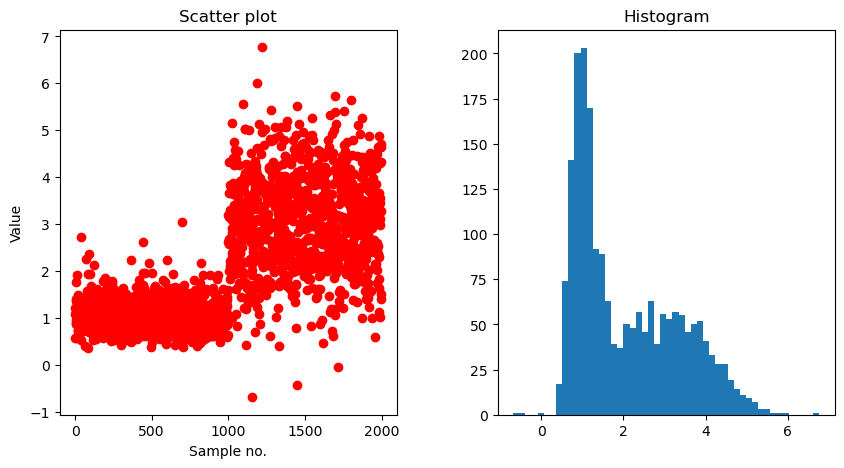

In [13]:
x_train = generate_data()[:, np.newaxis] #generating data and reshaping it
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.subplot(121)
plt.scatter(np.arange(len(x_train)), x_train, c='red')
plt.xlabel('Sample no.')
plt.ylabel('Value')
plt.title('Scatter plot')
plt.subplot(122)
plt.hist(x_train, bins=50)
plt.title('Histogram')
fig.subplots_adjust(wspace=.3)
plt.show()

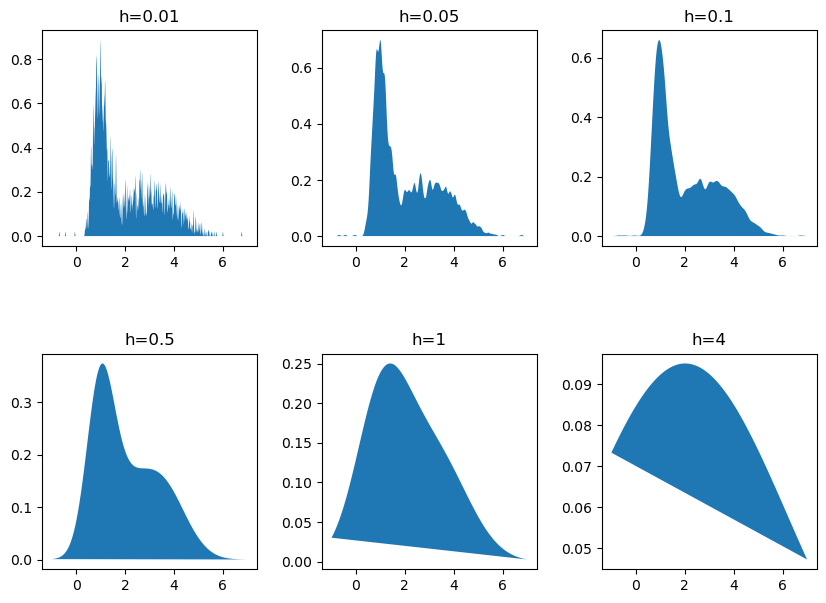

In [14]:
bandwidths = [0.01, 0.05, 0.1, 0.5, 1, 4]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
plt_ind = np.arange(6) + 231
x_test = np.linspace(-1, 7, 2000)[:, np.newaxis]


for b, ind in zip(bandwidths, plt_ind):
    kde_model = KernelDensity(kernel='gaussian', bandwidth=b)
    kde_model.fit(x_train)
    score = kde_model.score_samples(x_test)
    plt.subplot(ind)
    plt.fill(x_test, np.exp(score))
    plt.title("h="+str(b))

fig.subplots_adjust(hspace=0.5, wspace=.3)
plt.show()

Choise of $h$ is very important!

## KDE tasks

### Task 1


Update the kernel function (implement gaussian, epanechnikov, cosine, and linear kernels -- see the link given in kernel function) and Silverman's rule of thumb.

In [42]:
#solution 1: kernel function
def bounded(f): 
    def _f(x):
        return f(x) if np.abs(x) <= 1 else 0
    return _f


def kernel_selection(k: str):
    """Kernel Functions.
    Ref: https://en.wikipedia.org/wiki/Kernel_(statistics)

    Args:
        k (str): Kernel name. Can be one of ['gaussian', 'epanechnikov', 'cosine', 'linear'.]
    """
    kernel = k.lower()
    f = None
    if kernel == "gaussian":
        f = lambda u: np.exp(-u**2 / 2) / np.sqrt(2*np.pi)
    elif kernel == "epanechnikov":
        f = lambda u: 3*(1 - u**2) / 4
    elif kernel == "cosine":
        f = lambda u: np.pi/4 * np.cos(np.pi/2 * u)
    elif kernel == "linear":
        f = lambda u: 1 - np.abs(u) 
    else:
        raise ValueError("kernel name is invalid")

    return bounded(f) if kernel != "gaussian" else f 

In [43]:
#solution 1: Silverman's rule of thumb
def _select_sigma(data):
    """Sigma selection.
    Ref: https://en.wikipedia.org/wiki/Kernel_density_estimation

    Args:
        data (np.ndarray): Data
    """
    IQR = stats.iqr(data)
    return min(data.std(), IQR / 1.34)
    

def bw_silverman(data):
    """Bandwidth selection.
    Ref: https://en.wikipedia.org/wiki/Kernel_density_estimation

    Args:
        data (np.ndarray): Data
    """
    sigma = _select_sigma(data)
    return 0.9 * sigma * len(data) ** (-1/5)

In [44]:
#data preparation for the experiments
def make_data_normal(data_count=100):
    np.random.seed(rand_seed)
    x = np.random.normal(0, 1, data_count)
    dist = lambda z: stats.norm(0, 1).pdf(z)
    return x, dist

def make_data_binormal(data_count=100):
    alpha = 0.3
    np.random.seed(rand_seed)
    x = np.concatenate([
        np.random.normal(-1, 2, int(data_count * alpha)),
        np.random.normal(5, 1, int(data_count * (1 - alpha)))
    ])
    dist = lambda z: alpha * stats.norm(-1, 2).pdf(z) + (1 - alpha) * stats.norm(5, 1).pdf(z)
    return x, dist

def make_data_exp(data_count=100):
    alpha = 0.3
    np.random.seed(rand_seed)
    x = np.concatenate([
        np.random.exponential(1, int(data_count * alpha)),
        np.random.exponential(1, int(data_count * (1 - alpha))) + 1
    ])
    dist = lambda z: alpha * stats.expon(0).pdf(z) + (1 - alpha) * stats.expon(1).pdf(z)
    return x, dist

x_norm, dist_norm = make_data_normal()
x_binorm, dist_binorm = make_data_binormal()
x_exp, dist_exp = make_data_exp()

<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
/var/folders/n8/nv3d2csn3_l3w70gs_g9srfr0000gn/T/ipykernel_51198/1221711618.py:38: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(x_plot, x_kde, linewidth=1, label='$h_{\mathrm{' + bw[0] + '}} = ' + str(round(h, 5)) + '$')


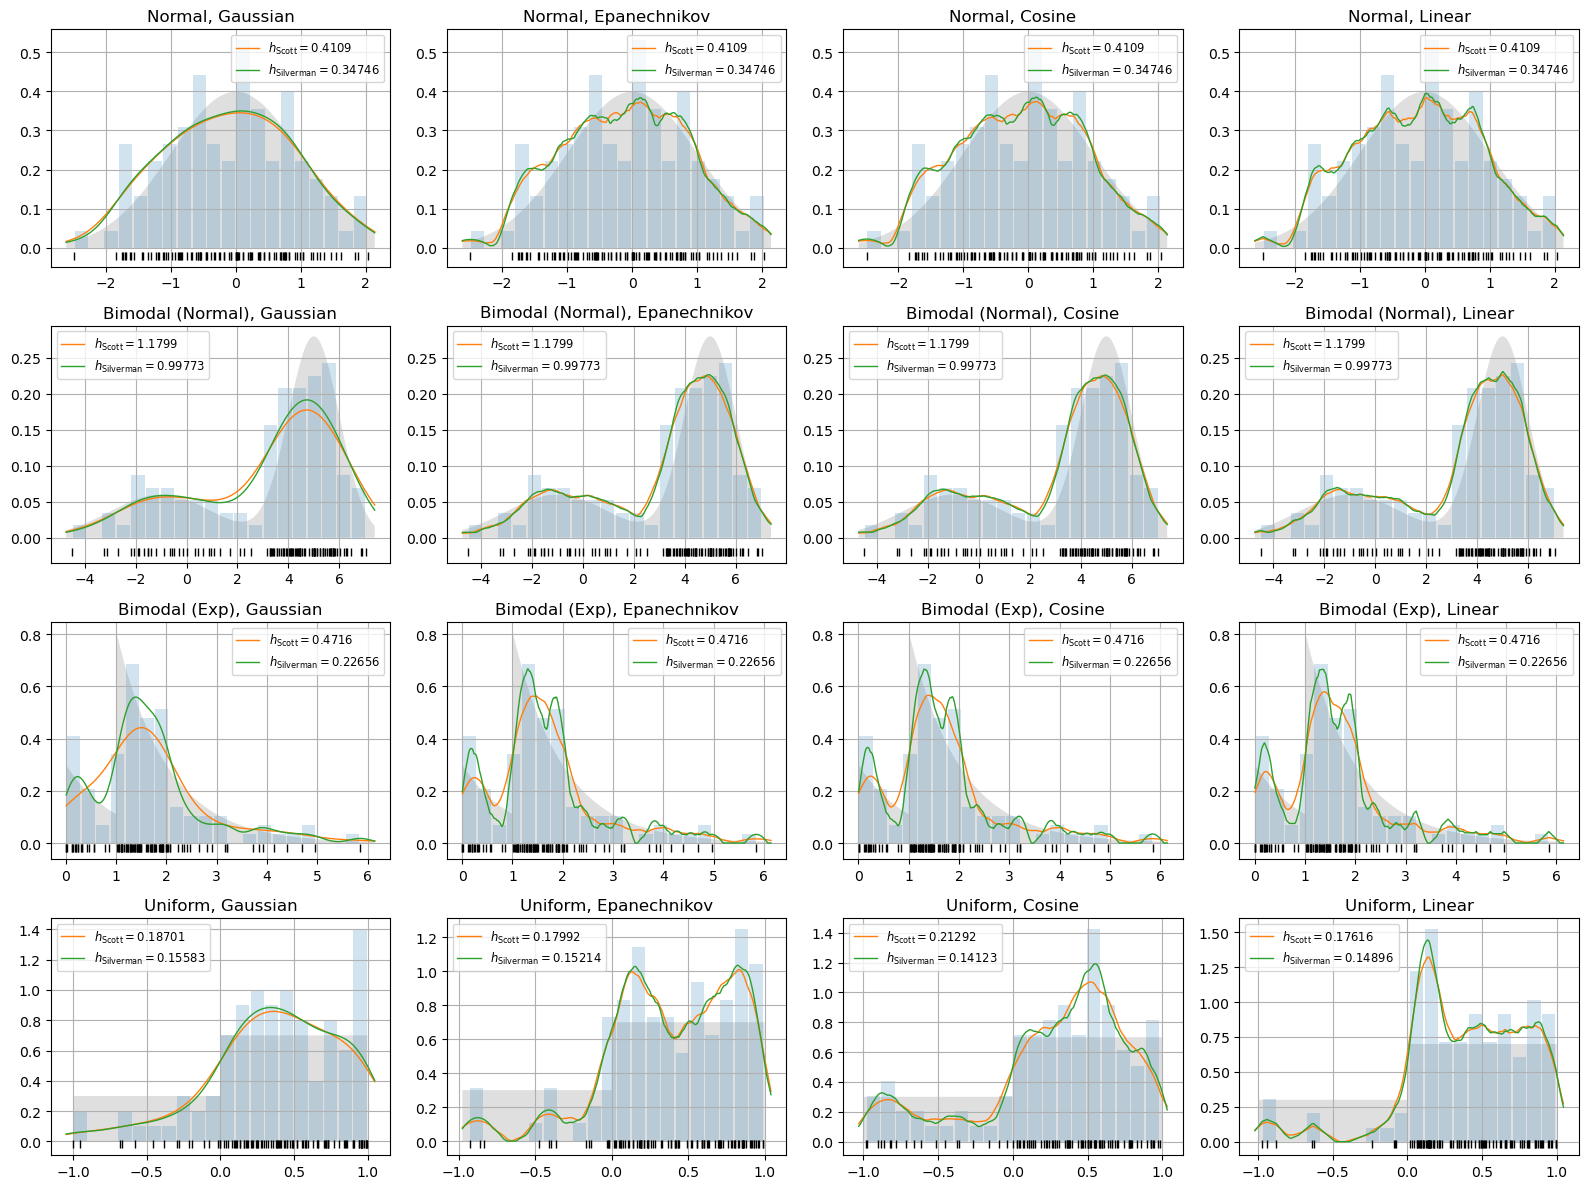

In [45]:
#experimentation part
data = [
    ('Normal', make_data_normal),
    ('Bimodal (Normal)', make_data_binormal),
    ('Bimodal (Exp)', make_data_exp),
    ('Uniform', make_data_uniform)
]
kernels = [
    ('Gaussian', kernel_selection('gaussian')),
    ('Epanechnikov', kernel_selection('epanechnikov')),
    ('Cosine', kernel_selection('cosine')),
    ('Linear', kernel_selection('linear'))
]
bw_algorithms = [
    ('Scott', bw_scott),
    ('Silverman', bw_silverman)
]
mses = []

def run_kde(ax, data, kernel):
    x, dist = data[1]()
    x_plot = np.linspace(np.min(x) * 1.05, np.max(x) * 1.05, 1000)
    ax.grid(True)
    ax.fill_between(x_plot, dist(x_plot), fc='silver', alpha=0.5)
    ax.plot(x, np.full_like(x, -0.02), '|k', markeredgewidth=1)
    ax.hist(x, density=True, alpha=0.2, bins=20, rwidth=0.9)
    for bw in bw_algorithms:
        h = bw[1](x)
        x_kde = kde(x, kernel[1], h=h, x=x_plot)
        mse = np.mean((dist(x_plot) - x_kde) ** 2)
        mses.append({
            'data': data[0],
            'kernel': kernel[0],
            'bw_algorithm': bw[0],
            'h': round(h, 5),
            'mse': round(mse * 1000, 5),
        })
        ax.plot(x_plot, x_kde, linewidth=1, label='$h_{\mathrm{' + bw[0] + '}} = ' + str(round(h, 5)) + '$')
    ax.legend(loc='best', fontsize='small')
    ax.set_title(f'{data[0]}, {kernel[0]}')

fig, axs = plt.subplots(len(data), len(kernels), figsize=(16, 12))
for i, d in enumerate(data):
    for j, k in enumerate(kernels):
        run_kde(axs[i, j], d, k)
    for bw in bw_algorithms:
        avg_h = np.mean([m['h'] for m in mses if m['data'] == d[0] and m['bw_algorithm'] == bw[0]])
        avg_mse = np.mean([m['mse'] for m in mses if m['data'] == d[0] and m['bw_algorithm'] == bw[0]])
        mses.append({
            'data': d[0],
            'kernel': '-',
            'bw_algorithm': bw[0],
            'h': round(avg_h, 5),
            'mse': round(avg_mse, 5),
        })

fig.tight_layout()

The best pairs of distribution-kernels are:
1. Normal distribution -- Gaussian kernel
2. Normal Bimodal distribution -- all kernels except for Gaussian worked equally great
3. Exponential Bimodal distribution -- all kernels except for Gaussian worked similarly (can't say great, but good enough)
4. Uniform -- Gaussian kernel

### Task 2

You have a dataset containing Apple's (AAPL) stock data for the last several years. Your task is to

1. check how well the default kde function from scikit learn fits your data;

2. run a greed search for 2 or more parameters in KDE to find the optimal ones;

3. check how well the found KDE fits your data;

4. set all the necessary titles, legends and axes' limits to have figures as given ones.

In [46]:
stocks = pd.read_csv('finance-charts-apple.csv').loc[:,['Date','AAPL.Open',
                                                        'AAPL.High','AAPL.Low',
                                                        'AAPL.Close','AAPL.Volume']]
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks.set_index(stocks['Date'], inplace=True)
stocks.head(5)

,Date,AAPL.Open,AAPL.High,AAPL.Low,AAPL.Close,AAPL.Volume
Date,,,,,,
2015-02-17,2015-02-17,127.489998,128.880005,126.919998,127.830002,63152400
2015-02-18,2015-02-18,127.629997,128.779999,127.449997,128.720001,44891700
2015-02-19,2015-02-19,128.479996,129.029999,128.330002,128.449997,37362400
2015-02-20,2015-02-20,128.619995,129.500000,128.050003,129.500000,48948400
2015-02-23,2015-02-23,130.020004,133.000000,129.660004,133.000000,70974100


In [47]:
#calculating the daily returns
stocks['pct_change'] = stocks['AAPL.Close'].pct_change()
stocks.dropna(inplace=True)
stocks.head(5)

,Date,AAPL.Open,AAPL.High,AAPL.Low,AAPL.Close,AAPL.Volume,pct_change
Date,,,,,,,
2015-02-18,2015-02-18,127.629997,128.779999,127.449997,128.720001,44891700,0.006962
2015-02-19,2015-02-19,128.479996,129.029999,128.330002,128.449997,37362400,-0.002098
2015-02-20,2015-02-20,128.619995,129.500000,128.050003,129.500000,48948400,0.008174
2015-02-23,2015-02-23,130.020004,133.000000,129.660004,133.000000,70974100,0.027027
2015-02-24,2015-02-24,132.940002,133.600006,131.169998,132.169998,69228100,-0.006241


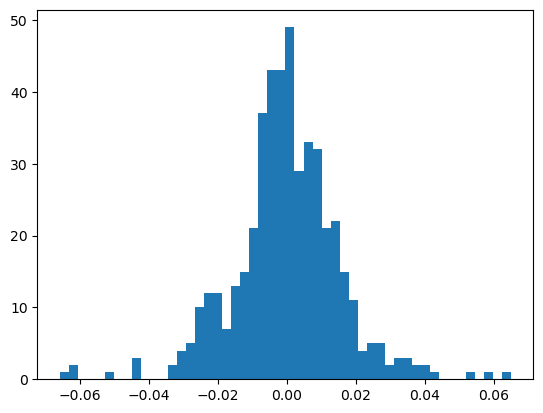

In [48]:
#selection of daily returns only for 2015-2016 year (the data you need work with)
train = stocks['2015':'2016']
train_returns = train['pct_change']
plt.hist(train_returns, bins=50);

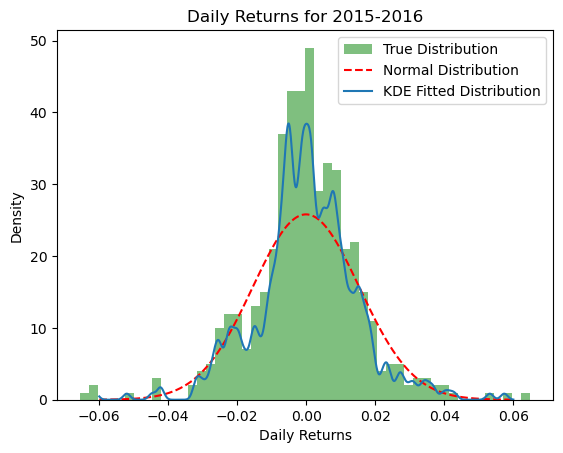

In [73]:
#solution 2.1
def normal_pdf(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

train_returns_arr = np.array(train_returns).reshape(-1, 1)
kde = KernelDensity(bandwidth = 0.001).fit(train_returns_arr)

mu, sigma = train_returns.mean(), train_returns.std()
xs = np.linspace(-0.06, 0.06, 1000)

#to-do: check what kde skicit-learn function returns
log_probs = kde.score_samples(xs.reshape(-1, 1))
kde_pdf = np.exp(log_probs)

#to-do: plot a histogram of train data's true distribution
plt.hist(train_returns_arr, bins=50, color='#7FBF7F', label="True Distribution")

#to-do: plot a normal curve
plt.plot(xs, normal_pdf(xs, train_returns_arr.mean(), train_returns_arr.std()), 'r--', label="Normal Distribution")

#to-do: plot a KDE curve
plt.plot(xs, kde_pdf, label="KDE Fitted Distribution")


plt.title('Daily Returns for 2015-2016')
plt.ylabel('Density')
plt.xlabel('Daily Returns')
plt.legend(loc='best')
None

The fitted distribution is not precise. Let's optimize the parameters!

In [78]:
#solution 2.2
from sklearn.model_selection import GridSearchCV

#to-do: make a dictionary of all the parameters you want to check
params = {
    "bandwidth": np.arange(1e-3, 0.01, 1e-6)
}

grid = GridSearchCV(KernelDensity(),
                    param_grid=params,
                    cv=20,
                    n_jobs=-1).fit(train_returns_arr)

grid.best_params_

{'bandwidth': 0.004199999999999731}

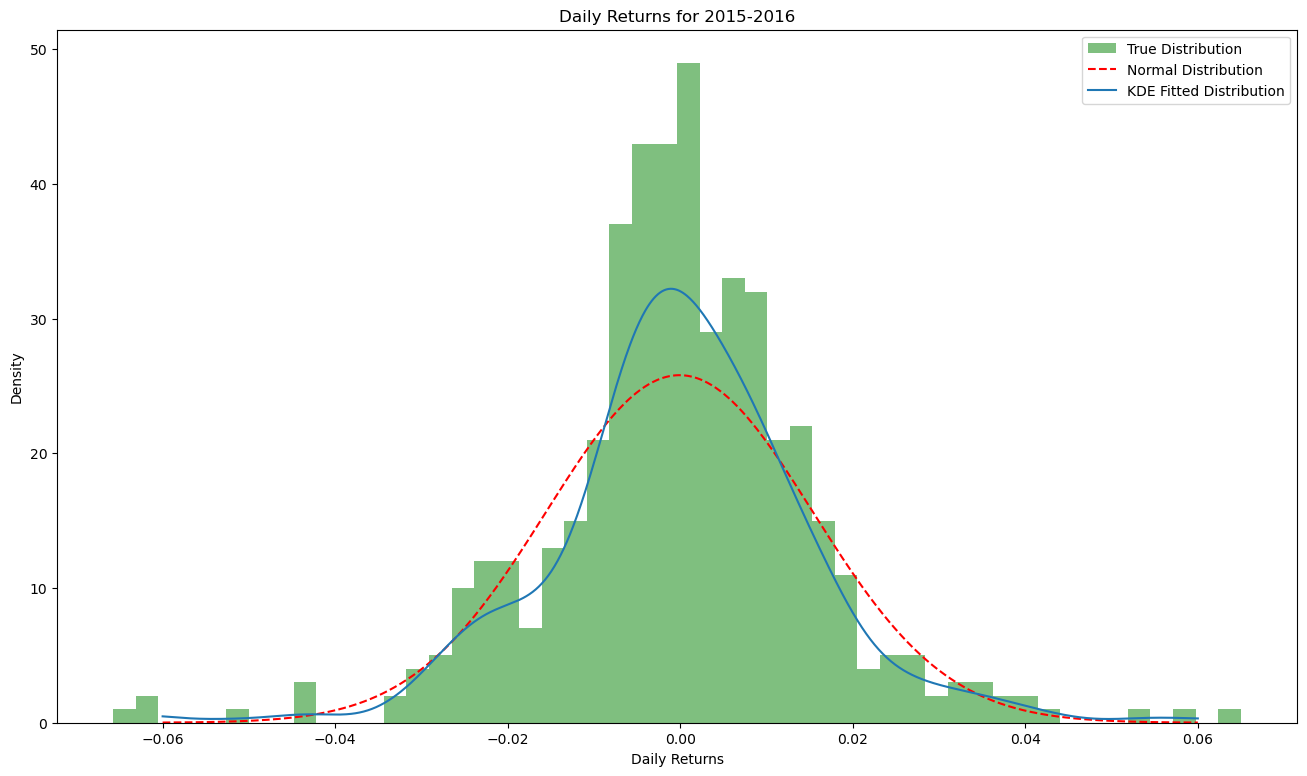

In [81]:
#solution 2.3
best_kde = KernelDensity(bandwidth=grid.best_params_['bandwidth']).fit(train_returns_arr)

log_probs = best_kde.score_samples(xs.reshape(-1,1))
best_kde_pdf = np.exp(log_probs)

plt.subplots(figsize=(16,9))

#to-do: plot a histogram of train data's true distribution
plt.hist(train_returns_arr, bins=50, color='#7FBF7F', label="True Distribution")

#to-do: plot a normal curve
plt.plot(xs, normal_pdf(xs, train_returns_arr.mean(), train_returns_arr.std()), 'r--', label="Normal Distribution")

#to-do: plot a KDE curve
plt.plot(xs, best_kde_pdf, label="KDE Fitted Distribution")

plt.title('Daily Returns for 2015-2016')
plt.ylabel('Density')
plt.xlabel('Daily Returns')
plt.legend(loc='best')

Text(0.5, 1.0, 'Zoomed Into Right Hand Side Fat Tails')

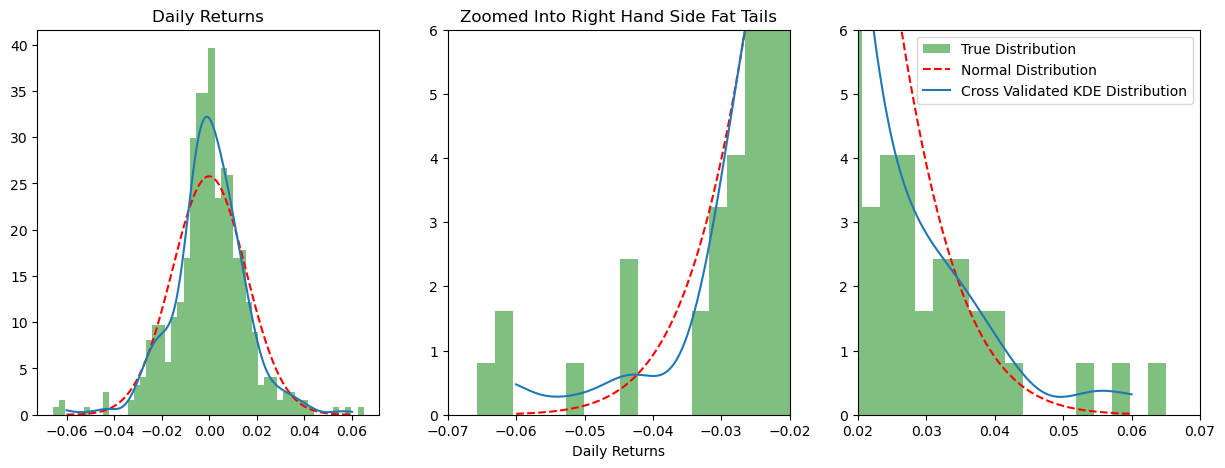

In [85]:
#solution 2.4
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i in range(3):
    ax[i].hist(train_returns, density=True, color='green', bins=50, alpha=0.5,
               histtype='stepfilled', label='True Distribution')
    ax[i].plot(xs, normal_pdf(xs, mu, sigma), color='red',
         linestyle='--', label='Normal Distribution')
    ax[i].plot(xs, best_kde_pdf, label='Cross Validated KDE Distribution')

#to-do: set labels, titles, and limits for your plots
ax[0].set_title("Daily Returns")
ax[1].set_xlim(-0.07, -0.02)
ax[1].set_ylim(0, 6)
ax[1].set_title("Zoomed Into Left Hand Side Fat Tails")
ax[1].set_xlabel("Daily Returns")
ax[2].set_xlim(0.02, 0.07)
ax[2].set_ylim(0, 6)
ax[2].legend()
ax[1].set_title("Zoomed Into Right Hand Side Fat Tails")

## Useful sources



*   [Beautiful vizualizations of CDF](https://plotly.com/python/ecdf-plots/)
*   [Several implementation of KDE](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/)
*   [How does KDE work?](https://medium.com/analytics-vidhya/kernel-density-estimation-kernel-construction-and-bandwidth-optimization-using-maximum-b1dfce127073)
*   [KDE plots](https://github.com/StephanieStallworth/Exploratory_Data_Analysis_Visualization_Python/blob/master/Python%20A-Z%20Movie%20Rating%20Data%20Visualization.ipynb)
*   [3D KDE](https://nbviewer.org/github/rasbt/pattern_classification/blob/master/parameter_estimation_techniques/parzen_window_technique.ipynb)
*   [KDE tutorial](https://www.homeworkhelponline.net/blog/math/tutorial-kde)
